In [ ]:
import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

path1 = kagglehub.dataset_download("nicholasjhana/energy-consumption-generation-prices-and-weather")

df = pd.read_csv(os.path.join(path1, 'energy_dataset.csv'))
df = df[['time', 'total load actual']].rename(columns={'time': 'timestamp', 'total load actual': 'load'})
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df = df.dropna().sort_values('timestamp').reset_index(drop=True)

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

final_data = df[['load', 'hour', 'day_of_week', 'month']].values

Using Colab cache for faster access to the 'energy-consumption-generation-prices-and-weather' dataset.


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_data)

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window, :])
        y.append(data[i + window, 0])
    return np.array(X), np.array(y)

window_size = 48
X, y = create_sequences(scaled_data, window_size)


train_size = 26280
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


370/370 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - loss: 0.0583 - val_loss: 0.0097
Epoch 2/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0132 - val_loss: 0.0062
Epoch 3/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 0.0097 - val_loss: 0.0046
Epoch 4/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 5/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 6/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 7/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 8/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 9/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 10/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 11/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 12/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 

272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
LSTM MAE: 423.1922422279537
LSTM RMSE: 601.8337488281347


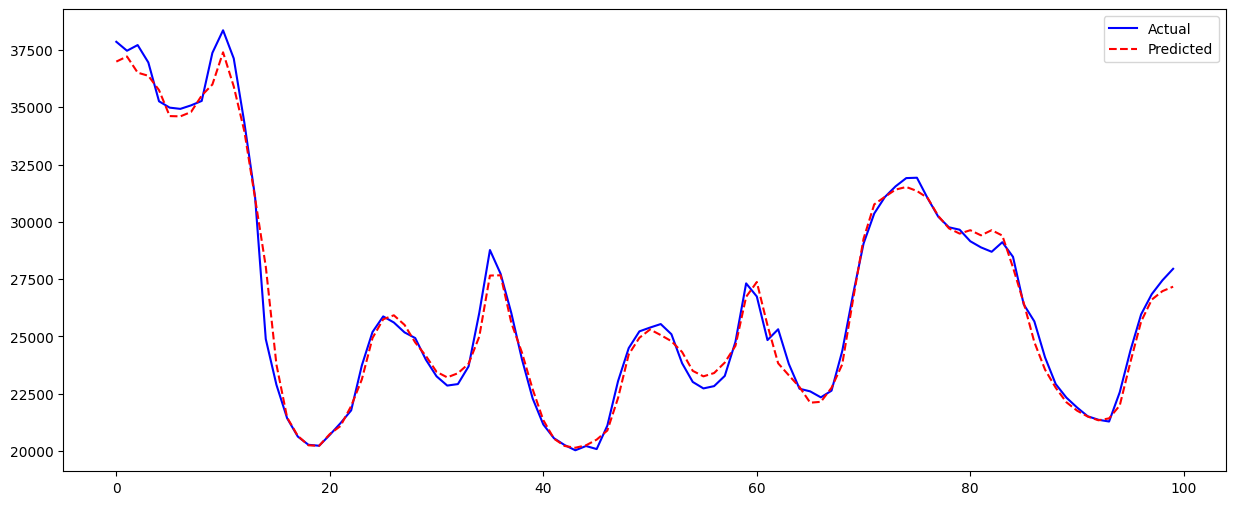

In [ ]:
predictions = model.predict(X_test)

pred_dummy = np.zeros((len(predictions), final_data.shape[1]))
pred_dummy[:, 0] = predictions.flatten()
predictions_unscaled = scaler.inverse_transform(pred_dummy)[:, 0]

actual_dummy = np.zeros((len(y_test), final_data.shape[1]))
actual_dummy[:, 0] = y_test
actual_unscaled = scaler.inverse_transform(actual_dummy)[:, 0]

mae = mean_absolute_error(actual_unscaled, predictions_unscaled)
rmse = np.sqrt(mean_squared_error(actual_unscaled, predictions_unscaled))

print(f"LSTM MAE: {mae}")
print(f"LSTM RMSE: {rmse}")

plt.figure(figsize=(15, 6))
plt.plot(actual_unscaled[:100], label='Actual', color='blue')
plt.plot(predictions_unscaled[:100], label='Predicted', color='red', linestyle='--')
plt.legend()
plt.show()

               Model          MAE
0  Linear Regression   403.427290
1      Random Forest   292.405267
2                KNN  1245.708598
3      Decision Tree   427.638506
4               LSTM   423.192242


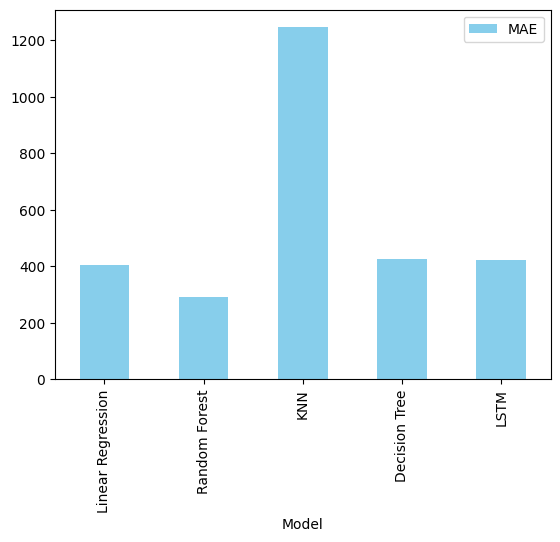

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

lr = LinearRegression().fit(X_train_flat, y_train)
rf = RandomForestRegressor(n_estimators=50, random_state=42).fit(X_train_flat, y_train)
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train_flat, y_train)
dt = DecisionTreeRegressor(random_state=42).fit(X_train_flat, y_train)

def get_mae(pred):
    dummy = np.zeros((len(pred), final_data.shape[1]))
    dummy[:, 0] = pred
    return mean_absolute_error(actual_unscaled, scaler.inverse_transform(dummy)[:, 0])

models = ['Linear Regression', 'Random Forest', 'KNN', 'Decision Tree', 'LSTM']
results = [get_mae(lr.predict(X_test_flat)), get_mae(rf.predict(X_test_flat)),
           get_mae(knn.predict(X_test_flat)), get_mae(dt.predict(X_test_flat)), mae]

performance_df = pd.DataFrame({'Model': models, 'MAE': results})
print(performance_df)

performance_df.plot(kind='bar', x='Model', y='MAE', color='skyblue')
plt.show()